In [ ]:
### TODO
#
# - clean the graph to simplify the problem
#   - FORMAT 1
#        - for nodes with multiple transactions between themselves, keep only one directed adge - remove all others. This edge will contain the number of transactions and the average amount of those transactions
#
#
#
#

In [27]:
import pandas as pd
import networkx as nx
import numpy as np

# 0.1%
#accounts_df = pd.read_csv("../datasets/p_0_1_percent/PS_20230428161042_1211346587/PS_20230428161042_1211346587_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_0_1_percent/PS_20230428161042_1211346587/PS_20230428161042_1211346587_rawLog.csv")

# 1%
#accounts_df = pd.read_csv("../datasets/p_1_percent/PS_20230504121043_87775/PS_20230504121043_87775_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_1_percent/PS_20230504121043_87775/PS_20230504121043_87775_rawLog.csv")

# 5%
accounts_df = pd.read_csv("../datasets/p_5_percent/PS_20230504134819_26105/PS_20230504134819_26105_account_attributes.csv")
transactions_df = pd.read_csv("../datasets/p_5_percent/PS_20230504134819_26105/PS_20230504134819_26105_rawLog.csv")

# 10%
#accounts_df = pd.read_csv("")
#transactions_df = pd.read_csv("")

# 20%
#accounts_df = pd.read_csv("")
#transactions_df = pd.read_csv("")

In [28]:
nodes_df = accounts_df
edges_df = transactions_df


nodes_df.head()
edges_df.head()

,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft
0,0,TRANSFER,94.57,C5393210639,94.57,0.0,CC7736975753,0.0,94.57,1,0,0
1,0,CASH_OUT,94.57,CC7736975753,94.57,0.0,M2927363590,0.0,0.00,1,0,0
2,0,TRANSFER,84.47,C2070951585,84.47,0.0,CC3218672791,0.0,84.47,1,0,0
3,0,CASH_OUT,84.47,CC3218672791,84.47,0.0,M3968125771,0.0,0.00,1,0,0
4,0,TRANSFER,91.27,C3284385768,91.27,0.0,CC3328636106,0.0,91.27,1,0,0


In [29]:
# create dummies for the 'action' column
dummies = pd.get_dummies(edges_df.action, prefix='action')

# concatenate the dummies to the original DataFrame
edges_df = pd.concat([edges_df, dummies], axis=1)

# drop the original 'action' column
edges_df.drop('action', axis=1, inplace=True)

edges_df.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,action_CASH_IN,action_CASH_OUT,action_DEBIT,action_PAYMENT,action_TRANSFER
0,0,94.57,C5393210639,94.57,0.0,CC7736975753,0.0,94.57,1,0,0,0,0,0,0,1
1,0,94.57,CC7736975753,94.57,0.0,M2927363590,0.0,0.00,1,0,0,0,1,0,0,0
2,0,84.47,C2070951585,84.47,0.0,CC3218672791,0.0,84.47,1,0,0,0,0,0,0,1
3,0,84.47,CC3218672791,84.47,0.0,M3968125771,0.0,0.00,1,0,0,0,1,0,0,0
4,0,91.27,C3284385768,91.27,0.0,CC3328636106,0.0,91.27,1,0,0,0,0,0,0,1


In [30]:
# Now we compute numerical indices for nameOrig and nameDest rather than their form 'CC6839167080'

# Create a dictionary that maps each unique original name to a new unique ID
node_ids = {node_name: i for i, node_name in enumerate(set(edges_df['nameOrig']).union(set(edges_df['nameDest'])))}


# Replace the original names with the new IDs
edges_df['nameOrig'] = edges_df['nameOrig'].map(node_ids)
edges_df['nameDest'] = edges_df['nameDest'].map(node_ids)

edges_df.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,action_CASH_IN,action_CASH_OUT,action_DEBIT,action_PAYMENT,action_TRANSFER
0,0,94.57,74371,94.57,0.0,59086,0.0,94.57,1,0,0,0,0,0,0,1
1,0,94.57,59086,94.57,0.0,25033,0.0,0.00,1,0,0,0,1,0,0,0
2,0,84.47,21116,84.47,0.0,71147,0.0,84.47,1,0,0,0,0,0,0,1
3,0,84.47,71147,84.47,0.0,46068,0.0,0.00,1,0,0,0,1,0,0,0
4,0,91.27,38372,91.27,0.0,74648,0.0,91.27,1,0,0,0,0,0,0,1


In [22]:
nodes_df.head()

,node_deg_in,node_deg_out,node_deg_total,node_min_balance,node_max_balance,node_min_new_balance,node_max_new_balance,node_mean_new_balance,node_mean_old_balance,node_std_new_balance,...,node_actions_dependent_out_function_TRANSFER,node_actions_dependent_out_function_CASHIN,node_actions_dependent_out_function_CASHOUT,node_actions_dependent_out_function_DEBIT,node_actions_dependent_out_function_PAYMENT,node_countains_flagged_fraud,node_countains_unauth_overdraft,node_in_isFraud,node_out_isFraud,node_isFraud
0,12.0,135.0,147.0,1480381.27,5235731.87,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,83.0,0.0,83.0,0.00,134403.47,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,79.0,0.0,79.0,0.00,182519.38,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,102.0,0.0,102.0,0.00,250806.46,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,82.0,0.0,82.0,0.00,166623.68,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
x_np = nodes_df.to_numpy()
x = x_np[:,0:-3]
x.shape

(82692, 41)

In [48]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.transforms import NormalizeFeatures

def visualize(h, color):
    z = TSNE(n_components=2, learning_rate='auto',
             init='random').fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

2.0.0


In [49]:
from torch.utils.data import random_split
# Define your graph
x = torch.nn.functional.normalize(torch.tensor(x),dim=0).to(torch.float32)  # (n x features)
edge_index =  torch.stack([torch.tensor(edges_df.nameOrig.to_numpy()),torch.tensor(edges_df.nameDest.to_numpy())],dim=-1).T  # Define your edge index
edge_attr = torch.nn.functional.normalize(torch.tensor(np.array(edges_df[['amount','oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest','isFlaggedFraud','isUnauthorizedOverdraft','action_CASH_IN','action_CASH_OUT','action_DEBIT','action_PAYMENT','action_TRANSFER']].values,dtype='float32')),dim=0) # edge features
y =  torch.tensor(nodes_df.node_isFraud.to_numpy().astype(int)) # target values

train_size = int(0.6 * len(y))  # 60% of the dataset for training
val_size = int(0.2 * len(y))    # 20% of the dataset for validation
test_size = len(y) - train_size - val_size  # Remaining 20% for testing

train_dataset, val_dataset, test_dataset = random_split(y, [train_size, val_size, test_size])

# Create masks for train, validation, and test sets
train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)

train_mask[train_dataset.indices] = True
val_mask[val_dataset.indices] = True
test_mask[test_dataset.indices] = True

In [50]:
from torch_geometric.data import Data
# Load your data into PyTorch Geometric's Data class
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)


In [51]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

print('==============================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Is weighted: {data.edge_weight is not None}')

print('==============================')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

Number of nodes: 82692
Number of edges: 3491520
Average node degree: 42.22
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Is weighted: False
Number of training nodes: 49615
Training node label rate: 0.60


In [52]:
import torch

from torch.nn import Linear
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

def random_walk_matrix(edge_index, num_nodes: int = None):
    source, target = edge_index[0], edge_index[1]
    in_deg = degree(target, num_nodes=num_nodes)   # D
    edge_weight = 1 / in_deg[target]               # D^-1 A
    return edge_index, edge_weight


class MPNN(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, in_channels2: int):
        super().__init__(aggr="add")                         # "sum" aggregation
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin_message = Linear(in_channels, out_channels, # weights 𝚯_1
                                  bias=False)
        self.lin_update = Linear(in_channels2, out_channels,  # weights 𝚯_2
                                 bias=True)                  # the bias vector 𝐛
        
        self.lin1 = Linear(in_channels, out_channels)
        self.lin2 = Linear(out_channels, out_channels)

    def forward(self, x, edge_index, edge_attr=None):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        # edge_attr has shape [E, edge_dim]
        #print('x', x.size())
        #print('edge_index', edge_index.size())
        #print('edge_attr', edge_attr.size())

        if edge_attr is None:
            edge_attr = torch.ones((edge_index.size(1), 1), device=x.device)
        # 1. m_j→𝑖 = x_j𝚯_1
        m_ji = self.lin_message(x)  # we can project here with isotropic GNNs
        #m_ji = x  # I decided since we only have one feature, it doesnt make sense to apply a linear to dim 16
        # 2. m_𝑖 = add(ã_ji ⋅ m_j→𝑖)_j∈𝑁(i)
        #print('mji', m_ji.size())
        m_i = self.propagate(edge_index, m=m_ji, edge_attr=edge_attr)
        # 3. h_𝑖 = tanh(x_i𝚯_2 + m_i + 𝐛)
        #print('mi', m_i.size())
        #h_i = torch.tanh(self.lin_update(x) + m_i)
        a = torch.cat([x, m_i], dim=-1)
        #print('ehh')
        #print('here', a.size())
        #print('ehh2')
        
        #print()
        #print('here2', self.lin_update(a).size())
        h_i = torch.tanh(self.lin_update(a))
        return h_i

    def message(self, m_j, edge_attr):
        # x_j has shape [E, in_channels]
        # edge_attr has shape [E, edge_dim]

        #print(m_j)
        #print(m_j.size())
        #print(edge_attr.size())
        #return edge_attr.reshape(-1, 1) * m_j
        #return edge_attr.view(-1, 1) * m_j
        return torch.cat([m_j, edge_attr], dim=-1)
        
        #The code return edge_attr.view(-1, 1) * x_j multiplies the input message x_j with the edge attributes edge_attr.
        #Here, x_j represents the message passed from the node j to its neighbor node i, and edge_attr represents the corresponding edge attribute associated with the edge connecting the nodes i and j.
        #The view(-1, 1) method call is used to reshape edge_attr to have one column and as many rows as there are messages passed between nodes. This is done so that the multiplication operation between x_j and edge_attr can be performed element-wise between the corresponding rows of x_j and edge_attr.
        #The resulting tensor has the same shape as x_j and represents the transformed messages to be aggregated by the receiving node i.

#    def message(self, m_j, edge_weight):
#        return edge_weight.view(-1, 1) * m_j  # ã_ji ⋅ m_j→𝑖


In [53]:
import torch

from torch.nn import Linear

HIDDEN_SIZE = 16 #@param
NUM_LAYERS = 2 #@param

dataset_num_node_features = x.size(1)
dataset_num_edge_features = edge_attr.size(1)
dataset_num_classes = 2

class GNNModel(torch.nn.Module):

    def __init__(self, hidden_size: int,
                 num_layers: int = 1):
        super().__init__()
        torch.manual_seed(12345)

        self.mpnns = torch.nn.ModuleList()
        for l in range(num_layers):
            #in_size = dataset_num_features if l == 0 else hidden_size
            in_size = dataset_num_node_features if l == 0 else hidden_size
            in_size2 = hidden_size + dataset_num_node_features + dataset_num_edge_features if l == 0 else hidden_size*2 + dataset_num_edge_features
            mpnn = MPNN(in_channels=in_size, out_channels=hidden_size, in_channels2=in_size2)
            self.mpnns.append(mpnn)

        self.lin_out = Linear(hidden_size, dataset_num_classes)
    
    def forward(self, x, edge_index, edge_attr=None):
        # Message-passing: transform node features based on neighbors
        for mpnn in self.mpnns:
            #x = mpnn(x, edge_index, edge_weight)
            x = mpnn(x, edge_index, edge_attr=edge_attr)
        # Decoder: post-process extracted features
        out = self.lin_out(x)
        return out

model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
print(model)
print_model_size(model)

GNNModel(
  (mpnns): ModuleList(
    (0): MPNN(41, 16)
    (1): MPNN(16, 16)
  )
  (lin_out): Linear(in_features=16, out_features=2, bias=True)
)
Number of model (GNNModel) parameters:      4274


In [54]:
model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
model.eval()

out = model(data.x, data.edge_index, edge_attr=data.edge_attr)
#visualize(out, color=data.y)

In [55]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))

model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
      model.train()
      optimizer.zero_grad()
      # We now give as input also the graph connectivity
      #out = model(data.x, gso_index, gso_weight)
      out = model(data.x, data.edge_index, data.edge_attr)
      #print(len(out[data.train_mask]),len(data.y[data.train_mask]))
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index, data.edge_attr)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      return test_acc, test_out, test_pred

for epoch in range(1, 401):
    train_loss = train()
    val_loss, _, _ = test(data.val_mask)
    print(f'Epoch: {epoch:03d} - Training loss: {train_loss:.4f} - '
          f'Validation accuracy: {val_loss * 100:.2f}%')

<IPython.core.display.Javascript object>

Epoch: 001 - Training loss: 0.7890 - Validation accuracy: 47.46%
Epoch: 002 - Training loss: 0.7031 - Validation accuracy: 51.84%
Epoch: 003 - Training loss: 0.6970 - Validation accuracy: 55.67%
Epoch: 004 - Training loss: 0.6855 - Validation accuracy: 58.78%
Epoch: 005 - Training loss: 0.6734 - Validation accuracy: 60.39%
Epoch: 006 - Training loss: 0.6638 - Validation accuracy: 60.38%
Epoch: 007 - Training loss: 0.6570 - Validation accuracy: 66.03%
Epoch: 008 - Training loss: 0.6522 - Validation accuracy: 66.02%
Epoch: 009 - Training loss: 0.6483 - Validation accuracy: 66.02%
Epoch: 010 - Training loss: 0.6452 - Validation accuracy: 66.02%
Epoch: 011 - Training loss: 0.6429 - Validation accuracy: 66.02%
Epoch: 012 - Training loss: 0.6414 - Validation accuracy: 66.02%
Epoch: 013 - Training loss: 0.6408 - Validation accuracy: 66.02%
Epoch: 014 - Training loss: 0.6408 - Validation accuracy: 66.02%
Epoch: 015 - Training loss: 0.6409 - Validation accuracy: 66.02%
Epoch: 016 - Training los

KeyboardInterrupt: 

In [56]:
test_acc, test_out, test_pred  = test(data.test_mask)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
print(test_pred)


Test Accuracy: 95.89%
tensor([0, 0, 0,  ..., 0, 1, 1])


In [57]:
out = model(data.x, data.edge_index, data.edge_attr)
#visualize(out, color=data.y)
#visualize(out[data.test_mask], color=data.y[data.test_mask])

[0.00422117 0.47074187 0.00958515 ... 0.00688851 0.8157754  0.99851555]
Precision: 0.91
Recall: 0.98
F1-score: 0.94


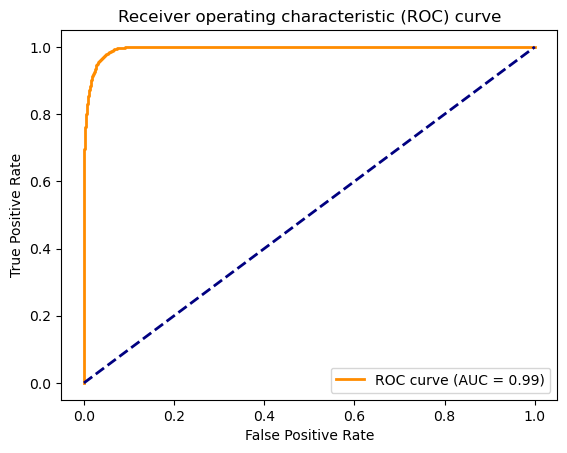

In [58]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import torch.nn.functional as F

y_true = data.y[data.test_mask]
y_pred = softmax_x = F.softmax(test_out, dim=1)
y_pred = y_pred[:, 1].detach().numpy()
print(y_pred)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, test_pred, average='binary')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
print(len(data.y[data.test_mask]))
print(len(y_pred))
orig_test_y = data.y[data.test_mask]
b = test_pred == orig_test_y
c = b[orig_test_y == 1]
print(np.sum(c.numpy()/len(c)))

c

11109
11109
0.0


tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 